In [101]:
from datetime import datetime
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from calendar import monthrange, month_name
from collections import defaultdict, OrderedDict
from pprint import pprint
import json
import requests

import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Elasticsearch should be running at this URL, otherwise the next command will give and error
ES_URL = "http://localhost:9200"

# Make an ElasticSearch instance
es = Elasticsearch(ES_URL)

# Name of organization.
org_name = "chaoss"

# Url from where github api will retrieve repositories data.
repo_url =  'https://api.github.com/users/'+org_name+'/repos'

# This token will allow us to call GitHub's api without being rate limited
token = "" # Add your own token

In [21]:
def retrieve_repos(url):
    response = requests.get(url)
    json_response=response.json()
    repo_list = []
    total_repos=len(json_response)
    for repo in range(total_repos):
        info={}
        info[json_response[repo]['name']] = [json_response[repo]['clone_url'],json_response[repo]['html_url']]
        repo_list.append(info)
        
    return repo_list

In [22]:
repo_list=retrieve_repos(repo_url)

In [44]:
repo_list[0]

{'governance': ['https://github.com/chaoss/governance.git',
  'https://github.com/chaoss/governance']}

In [75]:
no_of_repos=len(repo_list)
pprint(no_of_repos)

24


In [43]:
for repo_dict in repo_list:
    print('generating indexes for repo: ', next(iter(repo_dict)))
    subprocess.run(['p2o.py', '--enrich', '--index', next(iter(repo_dict))+'_git_raw',
      '--index-enrich', next(iter(repo_dict))+'_git', '-e', ES_URL,
      '--no_inc', '--debug', 'git', next(iter(repo_dict.values()))[0]])

    print("")

generating indexes for repo:  governance

generating indexes for repo:  grimoirelab

generating indexes for repo:  grimoirelab-bestiary

generating indexes for repo:  grimoirelab-cereslib

generating indexes for repo:  grimoirelab-elk

generating indexes for repo:  grimoirelab-hatstall

generating indexes for repo:  grimoirelab-kibiter

generating indexes for repo:  grimoirelab-kidash

generating indexes for repo:  grimoirelab-kingarthur

generating indexes for repo:  grimoirelab-manuscripts

generating indexes for repo:  grimoirelab-mordred

generating indexes for repo:  grimoirelab-perceval

generating indexes for repo:  grimoirelab-perceval-mozilla

generating indexes for repo:  grimoirelab-perceval-opnfv

generating indexes for repo:  grimoirelab-perceval-puppet

generating indexes for repo:  grimoirelab-sigils

generating indexes for repo:  grimoirelab-sortinghat

generating indexes for repo:  grimoirelab-toolkit

generating indexes for repo:  grimoirelab-tutorial

generating inde

In [70]:
def generate_no_of_commits(index):
    s = Search(using=es, index=index)
    s = s.source(['is_git_commit']).filter('range', commit_date ={'gte': 'now-3M'})
    s = s[0:10000]
    s = s.execute()
    total_commit=0
    for hits in s :
        total_commit+=hits.is_git_commit
    return total_commit

In [71]:
repo_total_commits={}
for repo_dict in repo_list:
    enriched_index=next(iter(repo_dict))+'_git'
    repo_total_commits[next(iter(repo_dict))]=generate_no_of_commits(enriched_index)
pprint(repo_total_commits)    

{'governance': 41,
 'grimoirelab': 78,
 'grimoirelab-bestiary': 134,
 'grimoirelab-cereslib': 20,
 'grimoirelab-elk': 298,
 'grimoirelab-hatstall': 64,
 'grimoirelab-kibiter': 66,
 'grimoirelab-kidash': 16,
 'grimoirelab-kingarthur': 28,
 'grimoirelab-manuscripts': 10,
 'grimoirelab-mordred': 118,
 'grimoirelab-perceval': 280,
 'grimoirelab-perceval-mozilla': 60,
 'grimoirelab-perceval-opnfv': 24,
 'grimoirelab-perceval-puppet': 0,
 'grimoirelab-sigils': 18,
 'grimoirelab-sortinghat': 45,
 'grimoirelab-toolkit': 16,
 'grimoirelab-tutorial': 30,
 'metrics': 21,
 'prospector': 0,
 'website': 59,
 'wg-diversity-inclusion': 16,
 'whitepaper': 6}


In [78]:
issue_total={}
pr_total={}
for repo in repo_list:
    issue_count=0
    pr_count=0
    repo_name=next(iter(repo))
    raw_index=repo_name+'_raw'
    enriched_index=repo_name+'_enriched_index'
    subprocess.run(['p2o.py', '--enrich', '--index', raw_index,
      '--index-enrich', enriched_index, '-e', ES_URL,
      '--no_inc', '--debug', 'github', org_name , repo_name,
      '-t',  token, '--sleep-for-rate'])
    print("generating indexes for: " + str(repo_name))
    s = Search(using=es ,index=enriched_index)
    s = s.filter("terms", item_type = ['issue', 'pull request'])
    s = s.filter('range', created_at ={'gte': 'now-3M'})
    s =  s.execute()
    for hits in s:
        if(hits.item_type == 'pull request'):
            pr_count+=1
        else:
            issue_count+=1
    issue_total[repo_name] = issue_count
    pr_total[repo_name] = pr_count
    

generating indexes for: governance
generating indexes for: grimoirelab
generating indexes for: grimoirelab-bestiary
generating indexes for: grimoirelab-cereslib
generating indexes for: grimoirelab-elk
generating indexes for: grimoirelab-hatstall
generating indexes for: grimoirelab-kibiter
generating indexes for: grimoirelab-kidash
generating indexes for: grimoirelab-kingarthur
generating indexes for: grimoirelab-manuscripts
generating indexes for: grimoirelab-mordred
generating indexes for: grimoirelab-perceval
generating indexes for: grimoirelab-perceval-mozilla
generating indexes for: grimoirelab-perceval-opnfv
generating indexes for: grimoirelab-perceval-puppet
generating indexes for: grimoirelab-sigils
generating indexes for: grimoirelab-sortinghat
generating indexes for: grimoirelab-toolkit
generating indexes for: grimoirelab-tutorial
generating indexes for: metrics
generating indexes for: prospector
generating indexes for: website
generating indexes for: wg-diversity-inclusion
ge

In [79]:
issue_total

{'governance': 0,
 'grimoirelab': 0,
 'grimoirelab-bestiary': 0,
 'grimoirelab-cereslib': 0,
 'grimoirelab-elk': 1,
 'grimoirelab-hatstall': 0,
 'grimoirelab-kibiter': 0,
 'grimoirelab-kidash': 0,
 'grimoirelab-kingarthur': 0,
 'grimoirelab-manuscripts': 0,
 'grimoirelab-mordred': 2,
 'grimoirelab-perceval': 0,
 'grimoirelab-perceval-mozilla': 0,
 'grimoirelab-perceval-opnfv': 1,
 'grimoirelab-perceval-puppet': 0,
 'grimoirelab-sigils': 0,
 'grimoirelab-sortinghat': 4,
 'grimoirelab-toolkit': 1,
 'grimoirelab-tutorial': 0,
 'metrics': 0,
 'prospector': 3,
 'website': 0,
 'wg-diversity-inclusion': 3,
 'whitepaper': 2}

In [80]:
pr_total

{'governance': 10,
 'grimoirelab': 0,
 'grimoirelab-bestiary': 10,
 'grimoirelab-cereslib': 0,
 'grimoirelab-elk': 9,
 'grimoirelab-hatstall': 10,
 'grimoirelab-kibiter': 0,
 'grimoirelab-kidash': 0,
 'grimoirelab-kingarthur': 10,
 'grimoirelab-manuscripts': 0,
 'grimoirelab-mordred': 8,
 'grimoirelab-perceval': 0,
 'grimoirelab-perceval-mozilla': 10,
 'grimoirelab-perceval-opnfv': 1,
 'grimoirelab-perceval-puppet': 0,
 'grimoirelab-sigils': 0,
 'grimoirelab-sortinghat': 6,
 'grimoirelab-toolkit': 4,
 'grimoirelab-tutorial': 0,
 'metrics': 0,
 'prospector': 0,
 'website': 0,
 'wg-diversity-inclusion': 7,
 'whitepaper': 4}

In [81]:
commit_issue_pr = [repo_total_commits, issue_total, pr_total]

In [88]:
data = pd.DataFrame(commit_issue_pr)

In [89]:
data=data.T

In [92]:
data.rename(columns= {0:'Total commits',1:'Total Issues',2:'Total Pull request'}, inplace =True)

In [94]:
data.head()

,Total commits,Total Issues,Total Pull request
governance,41,0,10
grimoirelab,78,0,0
grimoirelab-bestiary,134,0,10
grimoirelab-cereslib,20,0,0
grimoirelab-elk,298,1,9


In [95]:
data['Total'] = data.sum(axis=1)

In [96]:
data

,Total commits,Total Issues,Total Pull request,Total
governance,41,0,10,51
grimoirelab,78,0,0,78
grimoirelab-bestiary,134,0,10,144
grimoirelab-cereslib,20,0,0,20
grimoirelab-elk,298,1,9,308
grimoirelab-hatstall,64,0,10,74
grimoirelab-kibiter,66,0,0,66
grimoirelab-kidash,16,0,0,16
grimoirelab-kingarthur,28,0,10,38
grimoirelab-manuscripts,10,0,0,10


In [97]:
data.sort_values(by=['Total'], inplace=True)
data

,Total commits,Total Issues,Total Pull request,Total
grimoirelab-perceval-puppet,0,0,0,0
prospector,0,3,0,3
grimoirelab-manuscripts,10,0,0,10
whitepaper,6,2,4,12
grimoirelab-kidash,16,0,0,16
grimoirelab-sigils,18,0,0,18
grimoirelab-cereslib,20,0,0,20
metrics,21,0,0,21
grimoirelab-toolkit,16,1,4,21
wg-diversity-inclusion,16,3,7,26


In [98]:
data.to_csv('Sorted_Repositories.csv')

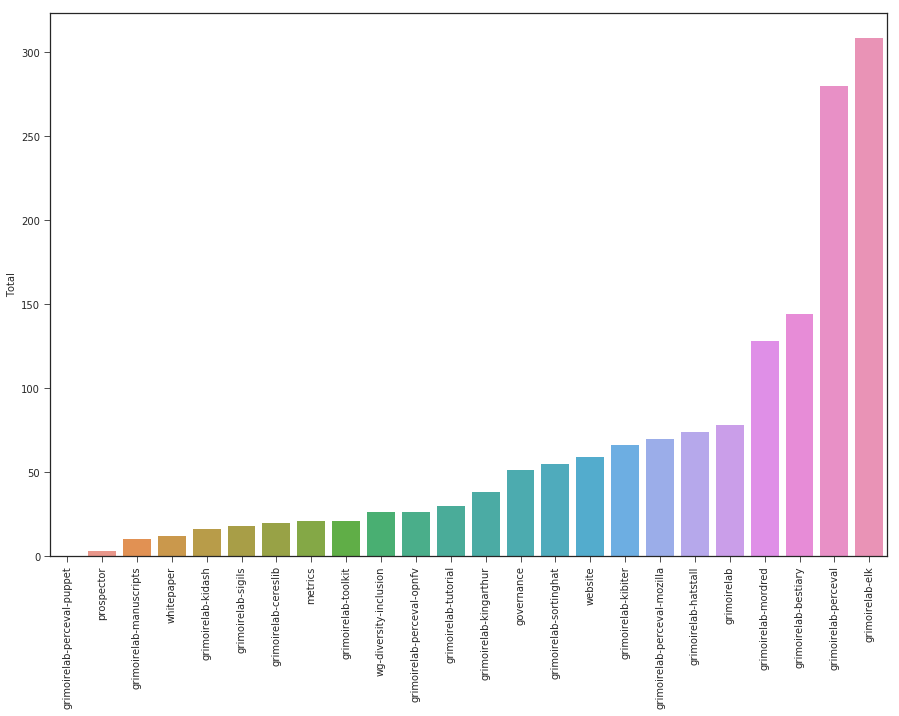

In [102]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of plot
fig.set_size_inches(15, 10)
sns.set_style("whitegrid")
sns.barplot(x=data.index, y="Total", data=data, ax=ax)
for item in ax.get_xticklabels():
    item.set_rotation(90)